In [ ]:
 # Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense)

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
from tqdm import tqdm, tqdm_pandas
import scipy
from scipy.stats import skew
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import sys
import IPython.display as ipd  # To play sound in the notebook
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [ ]:
def prepare_data(df, n,mfcc):
    X = np.empty(shape=(df.shape[0], n, 216, 1))
    input_length = sampling_rate * audio_duration
    
    cnt = 0
    for fname in tqdm(df.path):
        file_path = fname
        data, _ = librosa.load(file_path, sr=sampling_rate
                               ,res_type="kaiser_fast"
                               ,duration=2.5
                               ,offset=0.5
                              )

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, int(input_length) - len(data) - offset), "constant")


        if mfcc == 1:
            # MFCC extraction 
            MFCC = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=n_mfcc)
            MFCC = np.expand_dims(MFCC, axis=-1)
            X[cnt,] = MFCC

            
        cnt += 1
    
    return X


'''
3. Confusion matrix plot 
'''        
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    '''Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    '''
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
    
'''
# 4. Create the 2D CNN model 
'''
def get_2d_conv_model(n):
    ''' Create a standard deep 2D convolutional neural network'''
    nclass = 14
    inp = Input(shape=(n,216,1))  #2D matrix of 30 MFCC bands by 216 audio length.
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = Dropout(rate=0.2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(rate=0.2)(x)
    
    out = Dense(nclass, activation=softmax)(x)
    model = models.Model(inputs=inp, outputs=out)
    
    opt = Adam(0.001)
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model


In [ ]:

class get_results:
    '''We re going to create a class (blueprint template) for generating the results based on the various model approaches. 
    So instead of repeating the functions each time, we assign the results into on object with its associated variables 
    depending on each combination:
        1) MFCC with no augmentation  
        2) MFCC with augmentation 
        3) Logmelspec with no augmentation 
        4) Logmelspec with augmentation
    '''
    
    def __init__(self, model_history, model ,X_test, y_test, labels):
        self.model_history = model_history
        self.model = model
        self.X_test = X_test
        self.y_test = y_test             
        self.labels = labels

    def create_plot(self, model_history):
        '''Check the logloss of both train and validation, make sure they are close and have plateau'''
        plt.plot(model_history.history['loss'])
        plt.plot(model_history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    def create_results(self, model):
        '''predict on test set and get accuracy results'''
        opt = Adam(0.001)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        score = model.evaluate(X_test, y_test, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

    def confusion_results(self, X_test, y_test, labels, model):
        '''plot confusion matrix results'''
        preds = model.predict(X_test, 
                                 batch_size=16, 
                                 verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))

        classes = labels
        classes.sort()    

        c = confusion_matrix(actual, preds)
        print_confusion_matrix(c, class_names = classes)
    
    def accuracy_results_gender(self, X_test, y_test, labels, model):
        '''Print out the accuracy score and confusion matrix heat map of the Gender classification results'''
    
        preds = model.predict(X_test, 
                         batch_size=16, 
                         verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))
        
        # print(accuracy_score(actual, preds))
        
        actual = pd.DataFrame(actual).replace({'female_angry':'female'
                   , 'female_disgust':'female'
                   , 'female_fear':'female'
                   , 'female_happy':'female'
                   , 'female_sad':'female'
                   , 'female_surprise':'female'
                   , 'female_neutral':'female'
                   , 'male_angry':'male'
                   , 'male_fear':'male'
                   , 'male_happy':'male'
                   , 'male_sad':'male'
                   , 'male_surprise':'male'
                   , 'male_neutral':'male'
                   , 'male_disgust':'male'
                  })
        preds = pd.DataFrame(preds).replace({'female_angry':'female'
               , 'female_disgust':'female'
               , 'female_fear':'female'
               , 'female_happy':'female'
               , 'female_sad':'female'
               , 'female_surprise':'female'
               , 'female_neutral':'female'
               , 'male_angry':'male'
               , 'male_fear':'male'
               , 'male_happy':'male'
               , 'male_sad':'male'
               , 'male_surprise':'male'
               , 'male_neutral':'male'
               , 'male_disgust':'male'
              })

        classes = actual.loc[:,0].unique() 
        classes.sort()    

        c = confusion_matrix(actual, preds)
        print(accuracy_score(actual, preds))
        print_confusion_matrix(c, class_names = classes)

In [ ]:
%cd /content/drive/MyDrive/kaggle

/content/drive/MyDrive/kaggle


In [ ]:
ref = pd.read_csv("/content/drive/MyDrive/kaggle/Data_path.csv")
ref.head()

,labels,source,path
0,male_angry,SAVEE,/content/drive/MyDrive/kaggle/ALL/DC_a01.wav
1,male_angry,SAVEE,/content/drive/MyDrive/kaggle/ALL/DC_a13.wav
2,male_angry,SAVEE,/content/drive/MyDrive/kaggle/ALL/DC_a08.wav
3,male_angry,SAVEE,/content/drive/MyDrive/kaggle/ALL/DC_a07.wav
4,male_angry,SAVEE,/content/drive/MyDrive/kaggle/ALL/DC_a05.wav


In [ ]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc = prepare_data(ref, n = n_mfcc, mfcc = 1)

100%|██████████| 12162/12162 [1:40:26<00:00,  2.02it/s]


In [ ]:
mfcc

array([[[[-3.18349091e+02],
         [-2.89720184e+02],
         [-2.69758484e+02],
         ...,
         [-2.19427658e+02],
         [-2.09466095e+02],
         [-1.80118729e+02]],

        [[ 8.34498596e+01],
         [ 1.35305267e+02],
         [ 1.82354614e+02],
         ...,
         [ 2.29885590e+02],
         [ 2.38016663e+02],
         [ 2.48718140e+02]],

        [[-5.41240768e+01],
         [-7.18993473e+00],
         [ 1.69868202e+01],
         ...,
         [-4.90131569e+00],
         [-3.36635888e-01],
         [-1.15096724e+00]],

        ...,

        [[-1.35022755e+01],
         [-1.04322996e+01],
         [-5.50114012e+00],
         ...,
         [-5.92915154e+00],
         [ 1.05837762e-01],
         [ 4.77994442e+00]],

        [[-9.83723068e+00],
         [-9.57904816e+00],
         [-1.01752911e+01],
         ...,
         [-6.03088284e+00],
         [ 6.55138135e-01],
         [-2.04238668e-01]],

        [[ 2.71846294e+00],
         [ 1.74540329e+00],
         [

In [ ]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30

In [ ]:
import pickle

In [ ]:
with open('/content/drive/MyDrive/kaggle/mfcc.pickle','wb') as f :
  pickle.dump(mfcc,f)

In [ ]:
with open('/content/drive/MyDrive/kaggle/mfcc.pickle','rb') as f :
  mfcc = pickle.load(f)

In [ ]:
mfcc.shape

(12162, 30, 216, 1)

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(mfcc
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )


# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, verbose = 2, epochs=20)


Epoch 1/20
571/571 - 239s - loss: 2.2182 - acc: 0.2494 - val_loss: 1.8809 - val_acc: 0.3436
Epoch 2/20
571/571 - 237s - loss: 1.6635 - acc: 0.4174 - val_loss: 1.3594 - val_acc: 0.5094
Epoch 3/20
571/571 - 236s - loss: 1.4755 - acc: 0.4805 - val_loss: 1.3116 - val_acc: 0.5330
Epoch 4/20
571/571 - 235s - loss: 1.3598 - acc: 0.5202 - val_loss: 1.5059 - val_acc: 0.4854
Epoch 5/20
571/571 - 235s - loss: 1.2849 - acc: 0.5422 - val_loss: 1.1978 - val_acc: 0.5607
Epoch 6/20
571/571 - 235s - loss: 1.2334 - acc: 0.5617 - val_loss: 1.2315 - val_acc: 0.5534
Epoch 7/20
571/571 - 234s - loss: 1.1799 - acc: 0.5736 - val_loss: 1.0960 - val_acc: 0.5929
Epoch 8/20
571/571 - 234s - loss: 1.1400 - acc: 0.5877 - val_loss: 1.0432 - val_acc: 0.6146
Epoch 9/20
571/571 - 235s - loss: 1.1084 - acc: 0.6050 - val_loss: 1.2643 - val_acc: 0.5393
Epoch 10/20
571/571 - 234s - loss: 1.0746 - acc: 0.6082 - val_loss: 1.0774 - val_acc: 0.5929
Epoch 11/20
571/571 - 235s - loss: 1.0486 - acc: 0.6190 - val_loss: 1.0091 - va

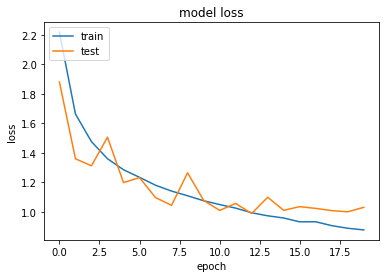

accuracy: 60.93%
191/191 - 14s


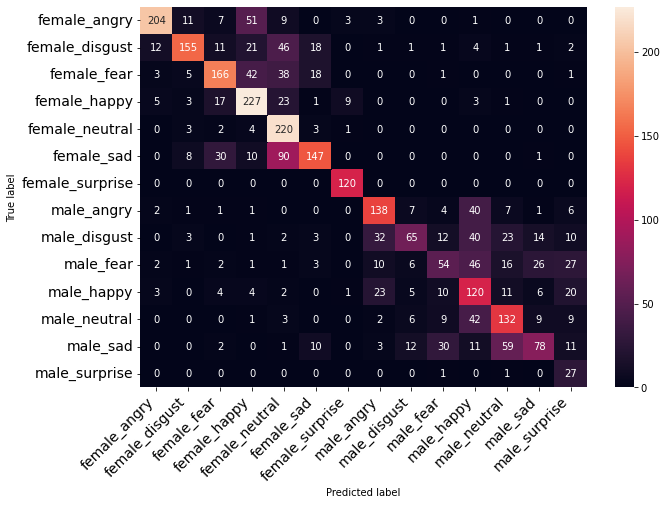

In [ ]:
results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, ref.labels.unique(), model)

In [ ]:
# Save model and weights
model_name = 'Emotion_Model_2D.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_2D_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /content/saved_models/Emotion_Model_2D.h5 


In [ ]:
from tensorflow.keras import optimizers

In [ ]:
# loading json and model architecture 
json_file = open('model_2D_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model_2D.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


accuracy: 60.93%


In [ ]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

191/191 [==============================] - 15s 80ms/step


array([ 4,  3,  8, ...,  9, 11,  0])

In [ ]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,male_sad,male_neutral
171,female_neutral,female_neutral
172,male_angry,male_angry
173,female_disgust,female_disgust
174,male_angry,male_angry
175,female_fear,female_happy
176,male_happy,male_angry
177,female_fear,female_fear
178,female_happy,female_happy
179,female_neutral,female_neutral


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [ ]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.88      0.71      0.78       289
 female_disgust       0.82      0.57      0.67       274
    female_fear       0.69      0.61      0.64       274
   female_happy       0.63      0.79      0.70       289
 female_neutral       0.51      0.94      0.66       233
     female_sad       0.72      0.51      0.60       286
female_surprise       0.90      1.00      0.94       120
     male_angry       0.65      0.66      0.66       208
   male_disgust       0.64      0.32      0.42       205
      male_fear       0.44      0.28      0.34       195
     male_happy       0.39      0.57      0.47       209
   male_neutral       0.53      0.62      0.57       213
       male_sad       0.57      0.36      0.44       217
  male_surprise       0.24      0.93      0.38        29

       accuracy                           0.61      3041
      macro avg       0.61      0.63      0.59      3041
   weighted avg       0.64   